# Testing for FCC Cats and Dogs Project

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import numpy as np

In [2]:
def view_random_image(target_dir, target_class):
    # Setup the target directory
    target_folder = target_dir + '/' + target_class
    
    # get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + '/'  + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    
    # Show the shape of the image
    print(f'Image shape: {img.shape}')
    
    return img

['dog.930.jpg']
Image shape: (244, 250, 3)


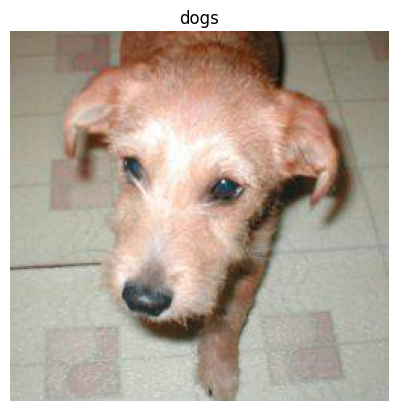

In [117]:
# View a random image from the training data set
img = view_random_image('cats_and_dogs/train', 'dogs')

In [3]:
# Create train and test data generators to rescale the data

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Dropout
from tensorflow.keras import Sequential

train_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

2023-01-24 14:25:29.946147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 14:25:30.189940: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-24 14:25:30.270990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-24 14:25:30.271007: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [5]:
# Set global seed for reproducability
#tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [5]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')
# Get number of files in each directory. The train and validation directories
# each have the subdirectories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(val_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 32
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [7]:
# Load in our image data and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, 
                                               target_size=(150,150),
                                              class_mode='binary',
                                              batch_size=32)

                                    
val_data = val_datagen.flow_from_directory(directory=val_dir, 
                                               target_size=(150,150),
                                              class_mode='binary',
                                              batch_size=32)

test_data = test_datagen.flow_from_directory(directory='cats_and_dogs',
                                                    target_size=(150,150),
                                                    batch_size=50,
                                                    classes=['test'],                                             
                                                    class_mode=None,
                                                    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [10]:
# Check classes found
print(train_data.class_indices)
print(val_data.class_indices)
print(test_data.class_indices)

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}
{'test': 0}


## Evaluation Functions

In [20]:
# plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss'])) # how many epochs we ran for
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    
    # plot loss
    ax1.plot(epochs, loss, label='training_loss')
    ax1.plot(epochs, val_loss, label='val_loss')
    ax1.set_title('loss')
    ax1.set_xlabel('epochs')
    ax1.legend()
    
    # plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy')
    ax2.plot(epochs, val_accuracy, label='val_accuracy')
    ax2.set_title('accuracy')
    ax2.set_xlabel('epochs')
    ax2.legend()

In [15]:
def test_score(model, test_data):
    probabilities = np.ndarray.flatten(model.predict(test_data))
        
    answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
                1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
                1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
                1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
                0, 0, 0, 0, 0, 0]

    correct = 0

    for probability, answer in zip(probabilities, answers):
      if round(probability) == answer:
        correct +=1

    percentage_identified = (correct / len(answers)) * 100

    passed_challenge = percentage_identified >= 63

    print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

    if passed_challenge:
      print("You passed the challenge!")
    else:
      print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

    return percentage_identified

In [92]:
# function to display images with optional probabilities
def plot_images(images_arr, probabilities=False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))
    if probabilities is False:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, [probability], ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if probability > 0.5:
                ax.set_title('%.1f' % (probability*100) + '% dog')
            else:
                ax.set_title('%.1f' % ((1-probability)*100) + '% cat')
    plt.show()

In [102]:
# log results to CSV and plot the loss curves
from datetime import datetime

def log_results(model, history, test_data, val_data):
    timestamp = datetime.now()
    # gather data on the model's performance
    
    val_loss, val_accuracy = model_5.evaluate(val_data)
    test_accuracy = test_score(model_5, test_data)
    num_epochs = len(history_5.history['loss'])

    # write to CSV
    f = open('log.csv','w')
    f.write(f'{timestamp},{model_5.name},{val_loss},{val_accuracy},{test_accuracy},{num_epochs}\n')
    f.close()
    
    #plot loss curves
    plot_loss_curves(history)

## Model 1 - Baseline

In [17]:
# Create the baseline model
model_1 = Sequential([
    Conv2D(10, kernel_size=3, activation='relu', input_shape=(150,150,3)),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [18]:
model_1.compile(loss='binary_crossentropy', 
                optimizer=Adam(), 
                metrics=['accuracy'])

In [19]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 10)      280       
                                                                 
 conv2d_4 (Conv2D)           (None, 146, 146, 10)      910       
                                                                 
 conv2d_5 (Conv2D)           (None, 144, 144, 10)      910       
                                                                 
 flatten_1 (Flatten)         (None, 207360)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 207361    
                                                                 
Total params: 209,461
Trainable params: 209,461
Non-trainable params: 0
_________________________________________________________________


In [20]:
len(train_data), train_data.n / 32

(63, 62.5)

In [127]:
history_1 = model_1.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=val_data,
                       validation_steps=len(val_data))

Epoch 1/5
63/63 [==============================] - 5s 76ms/step - loss: 0.6910 - accuracy: 0.5540 - val_loss: 0.6631 - val_accuracy: 0.5990
Epoch 2/5
63/63 [==============================] - 5s 75ms/step - loss: 0.6425 - accuracy: 0.6510 - val_loss: 0.6649 - val_accuracy: 0.5890
Epoch 3/5
63/63 [==============================] - 6s 102ms/step - loss: 0.5156 - accuracy: 0.7485 - val_loss: 0.6637 - val_accuracy: 0.6350
Epoch 4/5
63/63 [==============================] - 7s 114ms/step - loss: 0.3451 - accuracy: 0.8525 - val_loss: 0.7221 - val_accuracy: 0.6220
Epoch 5/5
63/63 [==============================] - 8s 121ms/step - loss: 0.2064 - accuracy: 0.9265 - val_loss: 1.0856 - val_accuracy: 0.6130


In [103]:
# Check out the loss and accuracy of model_1
plot_loss_curves(history_1)

NameError: name 'history_1' is not defined

In [108]:
model_1.evaluate(val_data)

32/32 [==============================] - 1s 30ms/step - loss: 0.6619 - accuracy: 0.6770


[0.6619464755058289, 0.6769999861717224]

In [109]:
test_score(model_1, test_data)

1/1 [==============================] - 0s 114ms/step
Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!


## Model 2 - Add Max Pooling

In [29]:
model_2 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [30]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 10)      280       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 10)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 72, 72, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 10)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 34, 34, 10)        910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 10)      

In [31]:
model_2.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

In [32]:
history_2 = model_2.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=val_data,
                       validation_steps=len(val_data))

Epoch 1/5
63/63 [==============================] - 3s 47ms/step - loss: 0.6930 - accuracy: 0.5060 - val_loss: 0.6882 - val_accuracy: 0.5050
Epoch 2/5
63/63 [==============================] - 3s 44ms/step - loss: 0.6836 - accuracy: 0.5390 - val_loss: 0.6744 - val_accuracy: 0.5130
Epoch 3/5
63/63 [==============================] - 3s 44ms/step - loss: 0.6721 - accuracy: 0.5830 - val_loss: 0.6636 - val_accuracy: 0.6170
Epoch 4/5
63/63 [==============================] - 3s 45ms/step - loss: 0.6298 - accuracy: 0.6405 - val_loss: 0.6174 - val_accuracy: 0.6530
Epoch 5/5
63/63 [==============================] - 3s 47ms/step - loss: 0.5830 - accuracy: 0.6935 - val_loss: 0.6043 - val_accuracy: 0.6510


In [33]:
model_2.evaluate(val_data)

32/32 [==============================] - 1s 26ms/step - loss: 0.6043 - accuracy: 0.6510


[0.6043184995651245, 0.6510000228881836]

In [34]:
test_score(model_2, test_data)

1/1 [==============================] - 0s 103ms/step
Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!


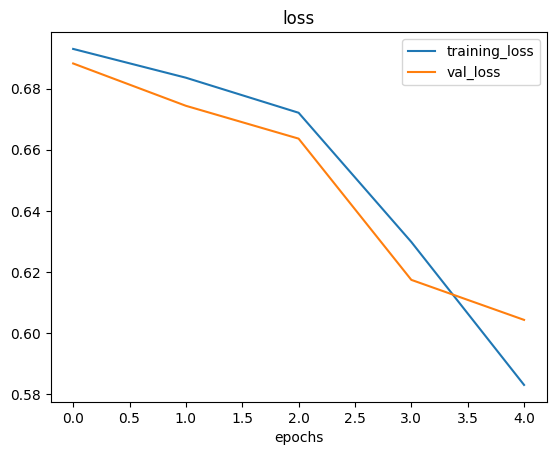

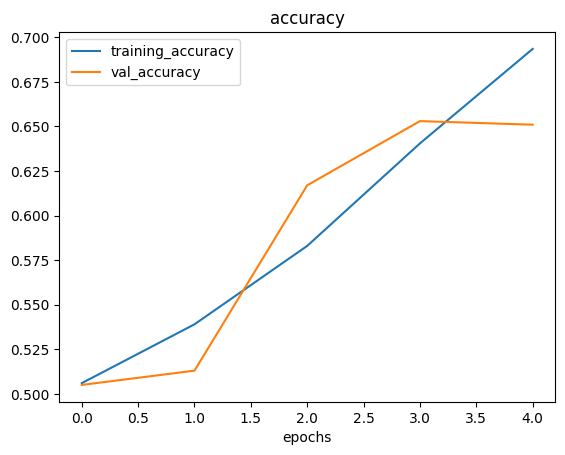

In [35]:
plot_loss_curves(history_2)

## Model 3 - Add More Filters

In [53]:
model_3 = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [54]:
model_3.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics='accuracy')

In [55]:
model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 32)      

In [56]:
history_3 = model_3.fit(train_data,
                       epochs=5,
                       steps_per_epoch=len(train_data),
                       validation_data=val_data,
                       validation_steps=len(val_data))

Epoch 1/5
63/63 [==============================] - 6s 97ms/step - loss: 0.6909 - accuracy: 0.5320 - val_loss: 0.6631 - val_accuracy: 0.6150
Epoch 2/5
63/63 [==============================] - 6s 95ms/step - loss: 0.6481 - accuracy: 0.6250 - val_loss: 0.6456 - val_accuracy: 0.6030
Epoch 3/5
63/63 [==============================] - 8s 125ms/step - loss: 0.5982 - accuracy: 0.6595 - val_loss: 0.6200 - val_accuracy: 0.6640
Epoch 4/5
63/63 [==============================] - 8s 130ms/step - loss: 0.5447 - accuracy: 0.7200 - val_loss: 0.5694 - val_accuracy: 0.7070
Epoch 5/5
63/63 [==============================] - 8s 129ms/step - loss: 0.5090 - accuracy: 0.7525 - val_loss: 0.5663 - val_accuracy: 0.7110


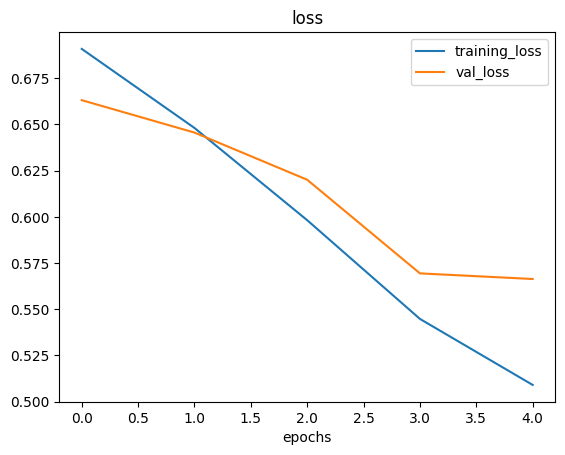

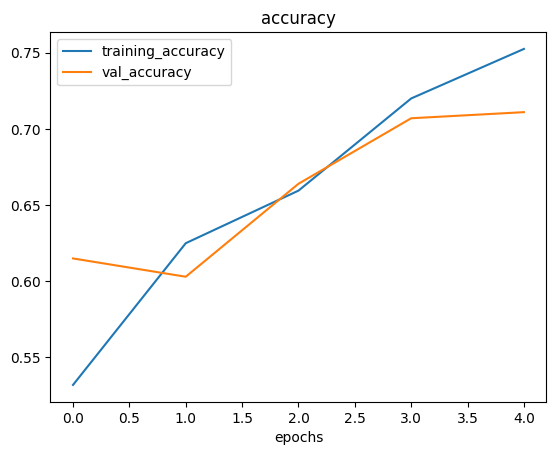

In [57]:
plot_loss_curves(history_3)

In [58]:
model_3.evaluate(val_data)

32/32 [==============================] - 1s 31ms/step - loss: 0.5663 - accuracy: 0.7110


[0.5663402676582336, 0.7110000252723694]

In [59]:
test_score(model_3, test_data)

1/1 [==============================] - 0s 138ms/step
Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!


## Model 4 - Add Augmentation

In [118]:
# Create ImageDataGenerator instance with data augmentation
train_datagen_aug = ImageDataGenerator(rescale=1/255.,
                                       rotation_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2,
                                       horizontal_flip=True)

# Import data from the training dir and augment it
train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                                      target_size=(150,150),
                                                      batch_size=32,
                                                      class_mode='binary')

In [12]:
# Build the model
model_4 = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(150,150,3)),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_4.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

history_4 = model_4.fit(train_data_aug,
                         epochs=15,
                         steps_per_epoch=len(train_data_aug),
                         validation_data=val_data,
                         validation_steps=len(val_data))

Found 2000 images belonging to 2 classes.
Epoch 1/15
63/63 [==============================] - 10s 152ms/step - loss: 0.6880 - accuracy: 0.5410 - val_loss: 0.6591 - val_accuracy: 0.5980
Epoch 2/15
63/63 [==============================] - 10s 157ms/step - loss: 0.6532 - accuracy: 0.6160 - val_loss: 0.6286 - val_accuracy: 0.6040
Epoch 3/15
63/63 [==============================] - 12s 196ms/step - loss: 0.6165 - accuracy: 0.6645 - val_loss: 0.6034 - val_accuracy: 0.6840
Epoch 4/15
63/63 [==============================] - 14s 227ms/step - loss: 0.5917 - accuracy: 0.6725 - val_loss: 0.5672 - val_accuracy: 0.6850
Epoch 5/15
63/63 [==============================] - 16s 249ms/step - loss: 0.5826 - accuracy: 0.6880 - val_loss: 0.5904 - val_accuracy: 0.6730
Epoch 6/15
63/63 [==============================] - 16s 242ms/step - loss: 0.5628 - accuracy: 0.7130 - val_loss: 0.5537 - val_accuracy: 0.7040
Epoch 7/15
63/63 [==============================] - 14s 225ms/step - loss: 0.5344 - accuracy: 0.7335

In [13]:
model_4.evaluate(val_data)

32/32 [==============================] - 1s 32ms/step - loss: 0.5103 - accuracy: 0.7490


[0.5103356838226318, 0.7490000128746033]

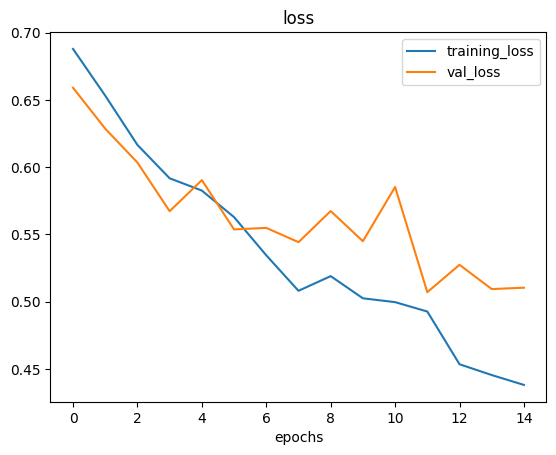

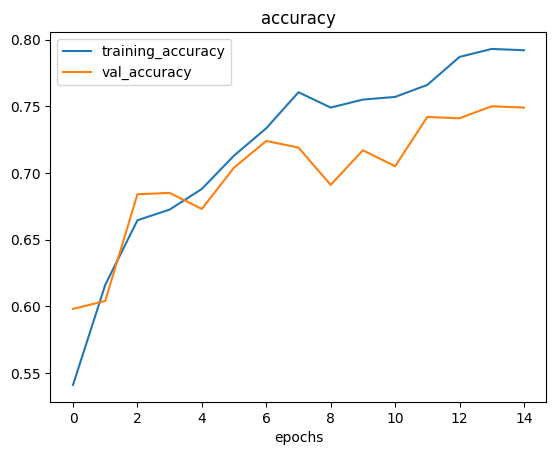

In [18]:
plot_loss_curves(history_4)

In [19]:
test_score(model_4, test_data)

1/1 [==============================] - 0s 147ms/step
Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!


### Notes
- added augmentation with 6 types. Performance was ok
- getting rid of height and width shift, and going up to 10 epochs I got 76%!
- moved up to 15 epochs and got 78%!! 🔥
- multiple runs were 78, 74, 78 on FCC test
- ~73-74% on val_data

## Model 5 - Add additional layers

Add another pair of Conv2D and MaxPool2D layers, and another Dense layer

In [118]:
# Create ImageDataGenerator instance with data augmentation
train_datagen_aug = ImageDataGenerator(rescale=1/255.,
                                       rotation_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2,
                                       horizontal_flip=True)

# Import data from the training dir and augment it
train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                                      target_size=(150,150),
                                                      batch_size=32,
                                                      class_mode='binary')

In [105]:
# Build the model
model_5 = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(150,150,3)),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_5.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

history_5 = model_5.fit(train_data_aug,
                         epochs=15,
                         steps_per_epoch=len(train_data_aug),
                         validation_data=val_data,
                         validation_steps=len(val_data))

Epoch 1/15
63/63 [==============================] - 16s 172ms/step - loss: 0.6943 - accuracy: 0.4940 - val_loss: 0.6912 - val_accuracy: 0.5030
Epoch 2/15
63/63 [==============================] - 12s 185ms/step - loss: 0.6924 - accuracy: 0.5240 - val_loss: 0.6911 - val_accuracy: 0.5120
Epoch 3/15
63/63 [==============================] - 14s 216ms/step - loss: 0.6928 - accuracy: 0.5255 - val_loss: 0.6896 - val_accuracy: 0.5560
Epoch 4/15
63/63 [==============================] - 13s 204ms/step - loss: 0.6891 - accuracy: 0.5320 - val_loss: 0.6865 - val_accuracy: 0.5150
Epoch 5/15
63/63 [==============================] - 13s 210ms/step - loss: 0.6706 - accuracy: 0.6015 - val_loss: 0.6542 - val_accuracy: 0.5990
Epoch 6/15
63/63 [==============================] - 13s 206ms/step - loss: 0.6538 - accuracy: 0.6130 - val_loss: 0.6674 - val_accuracy: 0.6280
Epoch 7/15
63/63 [==============================] - 12s 196ms/step - loss: 0.6330 - accuracy: 0.6470 - val_loss: 0.6529 - val_accuracy: 0.6210

In [106]:
model_5.evaluate(val_data)

32/32 [==============================] - 1s 35ms/step - loss: 0.5289 - accuracy: 0.7400


[0.5288768410682678, 0.7400000095367432]

In [107]:
test_score(model_5, test_data)

1/1 [==============================] - 0s 402ms/step
Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!


74.0

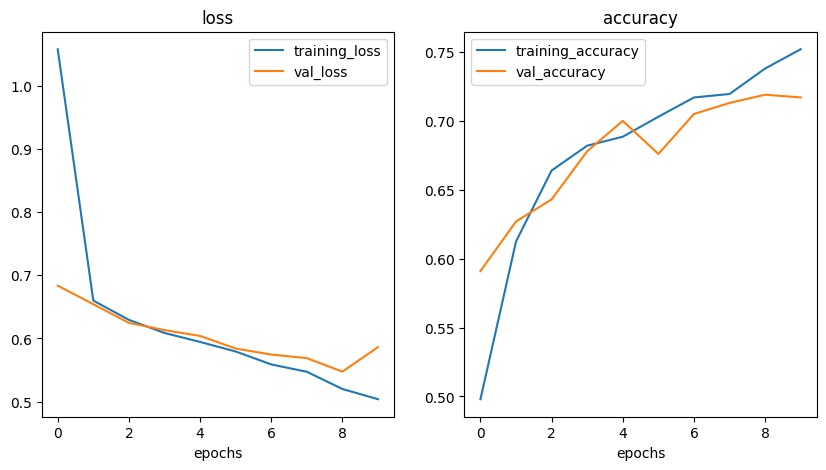

In [108]:
plot_loss_curves(history_6)

## Model 6 - Incrementally Increasing Neurons

In [109]:
# Create ImageDataGenerator instance with data augmentation
train_datagen_aug = ImageDataGenerator(rescale=1/255.,
                                       rotation_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2,
                                       horizontal_flip=True)

# Import data from the training dir and augment it
train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                                      target_size=(150,150),
                                                      batch_size=32,
                                                      class_mode='binary')

# Build the model
model_6 = Sequential([
    Conv2D(8, 3, activation='relu', input_shape=(150,150,3)),
    MaxPool2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_6.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

model_6.summary()

In [111]:
# fit for 20 epochs
history_6 = model_6.fit(train_data_aug,
                         epochs=20,
                         steps_per_epoch=len(train_data_aug),
                         validation_data=val_data,
                         validation_steps=len(val_data))

Epoch 1/20
63/63 [==============================] - 10s 143ms/step - loss: 0.6892 - accuracy: 0.5285 - val_loss: 0.6646 - val_accuracy: 0.5940
Epoch 2/20
63/63 [==============================] - 8s 123ms/step - loss: 0.6781 - accuracy: 0.5740 - val_loss: 0.6500 - val_accuracy: 0.6270
Epoch 3/20
63/63 [==============================] - 8s 127ms/step - loss: 0.6534 - accuracy: 0.6200 - val_loss: 0.6073 - val_accuracy: 0.6660
Epoch 4/20
63/63 [==============================] - 10s 159ms/step - loss: 0.6263 - accuracy: 0.6400 - val_loss: 0.6072 - val_accuracy: 0.6600
Epoch 5/20
63/63 [==============================] - 9s 147ms/step - loss: 0.5849 - accuracy: 0.6885 - val_loss: 0.5897 - val_accuracy: 0.6810
Epoch 6/20
63/63 [==============================] - 10s 151ms/step - loss: 0.5796 - accuracy: 0.6940 - val_loss: 0.5797 - val_accuracy: 0.6910
Epoch 7/20
63/63 [==============================] - 10s 154ms/step - loss: 0.5499 - accuracy: 0.7150 - val_loss: 0.5978 - val_accuracy: 0.6660
Ep

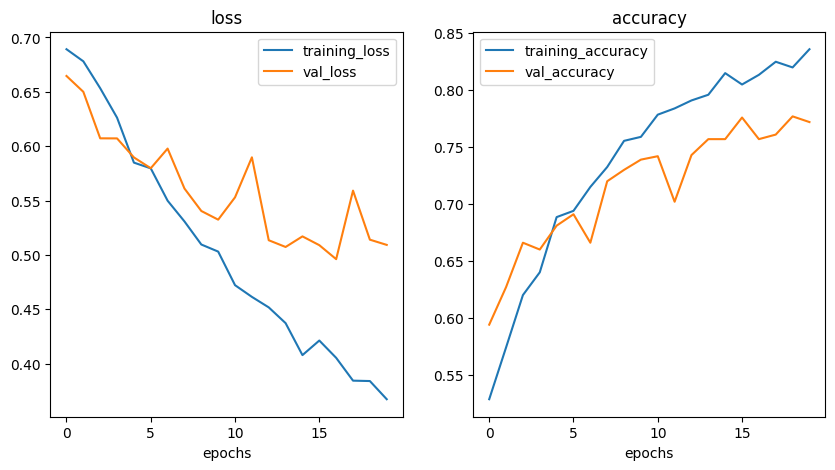

In [112]:
plot_loss_curves(history_6)

In [113]:
model_6.evaluate(val_data)

32/32 [==============================] - 1s 29ms/step - loss: 0.5092 - accuracy: 0.7720


[0.5092312097549438, 0.7720000147819519]

In [114]:
test_score(model_6, test_data)

1/1 [==============================] - 0s 130ms/step
Your model correctly identified 80.0% of the images of cats and dogs.
You passed the challenge!


80.0

### Experimentation Notes

- using 64 filters - 75.5% val, 72% FCC (about 30s/epoch)
- adding 1 more pair of Conv2D, MaxPool layers - 75% val, 72% FCC (about 13s/epoch)
- same, but with 20 epochs - 75.5% val, 78% FCC (val went as high as 78.2% on epoch 18!)
- same, and with another Dense layer with 32 neurons)
  - 1st attempt: 77.2% val, 82% FCC! Still trending well after 20 epochs
  - 2nd attempt: 78.% & 84%!! 🔥
  - 3rd attempt: 75.1% & 72% 😬
  - 4th attempt: 73.3% and 72%
- same, but with 25 epochs - 74.8% val, 74% FCC (val went as high as 80% on epoch 19!)
- increasing number of neurons (8, 16, 32, 64, 64), 20 epochs
  - 1st: 77.9% val, 82% FCC 🔥
  - 2nd: 77.2% val, 80% FCC

## Model 7 - Add Dropout

Add Dropout and train for 25 epochs

In [115]:
# Create ImageDataGenerator instance with data augmentation
train_datagen_aug = ImageDataGenerator(rescale=1/255.,
                                       rotation_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2,
                                       horizontal_flip=True)

# Import data from the training dir and augment it
train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                                      target_size=(150,150),
                                                      batch_size=32,
                                                      class_mode='binary')

# Build the model
model_7 = Sequential([
    Conv2D(8, 3, activation='relu', input_shape=(150,150,3)),
    MaxPool2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_7.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])


# fit for 20 epochs
history_7 = model_7.fit(train_data_aug,
                         epochs=25,
                         steps_per_epoch=len(train_data_aug),
                         validation_data=val_data,
                         validation_steps=len(val_data))

Found 2000 images belonging to 2 classes.
Epoch 1/25
63/63 [==============================] - 8s 121ms/step - loss: 0.6948 - accuracy: 0.5060 - val_loss: 0.6890 - val_accuracy: 0.5130
Epoch 2/25
63/63 [==============================] - 8s 127ms/step - loss: 0.6833 - accuracy: 0.5690 - val_loss: 0.6602 - val_accuracy: 0.6300
Epoch 3/25
63/63 [==============================] - 8s 135ms/step - loss: 0.6648 - accuracy: 0.5975 - val_loss: 0.6590 - val_accuracy: 0.6030
Epoch 4/25
63/63 [==============================] - 10s 162ms/step - loss: 0.6431 - accuracy: 0.6470 - val_loss: 0.6315 - val_accuracy: 0.6380
Epoch 5/25
63/63 [==============================] - 9s 147ms/step - loss: 0.6314 - accuracy: 0.6515 - val_loss: 0.6297 - val_accuracy: 0.6430
Epoch 6/25
63/63 [==============================] - 9s 146ms/step - loss: 0.6015 - accuracy: 0.6845 - val_loss: 0.5732 - val_accuracy: 0.6830
Epoch 7/25
63/63 [==============================] - 9s 146ms/step - loss: 0.5783 - accuracy: 0.6950 - val

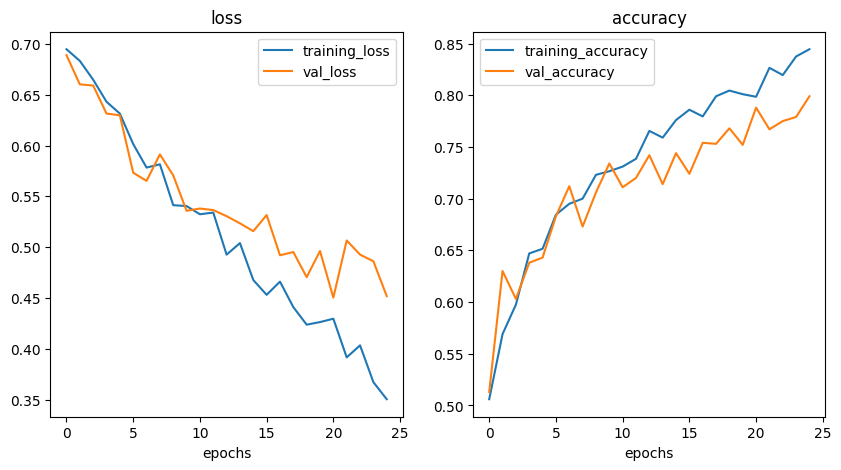

In [117]:
plot_loss_curves(history_7)

In [118]:
model_7.evaluate(val_data)

32/32 [==============================] - 1s 33ms/step - loss: 0.4518 - accuracy: 0.7990


[0.45175814628601074, 0.7990000247955322]

In [119]:
test_score(model_7, test_data)

1/1 [==============================] - 0s 159ms/step
Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!


78.0

## Model 8 - Try More Epochs, Early Stopping with Save

In [126]:
# Create ImageDataGenerator instance with data augmentation
train_datagen_aug = ImageDataGenerator(rescale=1/255.,
                                       rotation_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2,
                                       horizontal_flip=True)

# Import data from the training dir and augment it
train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                                      target_size=(150,150),
                                                      batch_size=32,
                                                      class_mode='binary')


# Build the model
model_8 = Sequential([
    Conv2D(8, 3, activation='relu', input_shape=(150,150,3)),
    MaxPool2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_8.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# fit for 20 epochs
history_8 = model_8.fit(train_data_aug,
                         epochs=35,
                         steps_per_epoch=len(train_data_aug),
                         validation_data=val_data,
                         validation_steps=len(val_data),
                         callbacks=[early_stop])

Found 2000 images belonging to 2 classes.
Epoch 1/35
63/63 [==============================] - 8s 116ms/step - loss: 0.6941 - accuracy: 0.4930 - val_loss: 0.6862 - val_accuracy: 0.5000
Epoch 2/35
63/63 [==============================] - 8s 130ms/step - loss: 0.6813 - accuracy: 0.5590 - val_loss: 0.6412 - val_accuracy: 0.6250
Epoch 3/35
63/63 [==============================] - 8s 121ms/step - loss: 0.6576 - accuracy: 0.6175 - val_loss: 0.6172 - val_accuracy: 0.6480
Epoch 4/35
63/63 [==============================] - 9s 142ms/step - loss: 0.6366 - accuracy: 0.6275 - val_loss: 0.6044 - val_accuracy: 0.6500
Epoch 5/35
63/63 [==============================] - 9s 142ms/step - loss: 0.6078 - accuracy: 0.6640 - val_loss: 0.5758 - val_accuracy: 0.7130
Epoch 6/35
63/63 [==============================] - 9s 143ms/step - loss: 0.5762 - accuracy: 0.7010 - val_loss: 0.5377 - val_accuracy: 0.7180
Epoch 7/35
63/63 [==============================] - 9s 141ms/step - loss: 0.5624 - accuracy: 0.7195 - val_

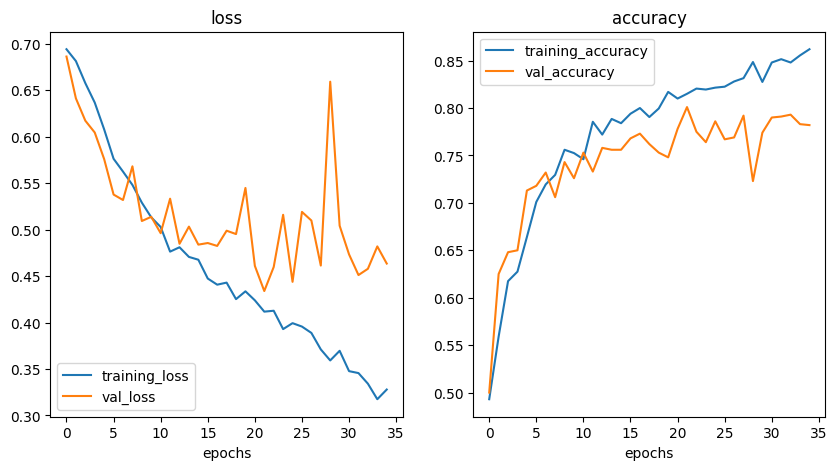

In [127]:
plot_loss_curves(history_8)

In [128]:
model_8.evaluate(val_data)

32/32 [==============================] - 1s 26ms/step - loss: 0.4635 - accuracy: 0.7820


[0.46345841884613037, 0.7820000052452087]

In [129]:
test_score(model_8, test_data)

1/1 [==============================] - 0s 153ms/step
Your model correctly identified 84.0% of the images of cats and dogs.
You passed the challenge!


84.0

## Model 9 - Use checkpoint callback to save  best weights

In [10]:
# Create ImageDataGenerator instance with data augmentation
train_datagen_aug = ImageDataGenerator(rescale=1/255.,
                                       rotation_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2,
                                       horizontal_flip=True)

# Import data from the training dir and augment it
train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                                      target_size=(150,150),
                                                      batch_size=32,
                                                      class_mode='binary')


# Build the model
model_9 = Sequential([
    Conv2D(8, 3, activation='relu', input_shape=(150,150,3)),
    MaxPool2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_9.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

# Callbacks
checkpoint_filepath = 'model_9_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# fit for 20 epochs
history_9 = model_9.fit(train_data_aug,
                         epochs=35,
                         steps_per_epoch=len(train_data_aug),
                         validation_data=val_data,
                         validation_steps=len(val_data),
                         callbacks=[checkpoint_callback])

Found 2000 images belonging to 2 classes.
Epoch 1/35
63/63 [==============================] - 9s 135ms/step - loss: 0.6914 - accuracy: 0.5270 - val_loss: 0.6854 - val_accuracy: 0.5790
Epoch 2/35
63/63 [==============================] - 8s 121ms/step - loss: 0.6817 - accuracy: 0.5570 - val_loss: 0.6518 - val_accuracy: 0.6340
Epoch 3/35
63/63 [==============================] - 10s 165ms/step - loss: 0.6650 - accuracy: 0.6065 - val_loss: 0.6512 - val_accuracy: 0.5920
Epoch 4/35
63/63 [==============================] - 11s 174ms/step - loss: 0.6496 - accuracy: 0.6205 - val_loss: 0.6286 - val_accuracy: 0.6470
Epoch 5/35
63/63 [==============================] - 12s 183ms/step - loss: 0.6178 - accuracy: 0.6635 - val_loss: 0.5962 - val_accuracy: 0.6760
Epoch 6/35
63/63 [==============================] - 11s 178ms/step - loss: 0.6017 - accuracy: 0.6855 - val_loss: 0.5979 - val_accuracy: 0.6740
Epoch 7/35
63/63 [==============================] - 10s 154ms/step - loss: 0.5994 - accuracy: 0.6800 -

In [12]:
# load the best model weights
model_9.load_weights(checkpoint_filepath)

In [13]:
model_9.evaluate(val_data)

32/32 [==============================] - 1s 26ms/step - loss: 0.4667 - accuracy: 0.7910


[0.46673598885536194, 0.7910000085830688]

In [16]:
test_score(model_9, test_data)

1/1 [==============================] - 0s 199ms/step
Your model correctly identified 84.0% of the images of cats and dogs.
You passed the challenge!


84.0

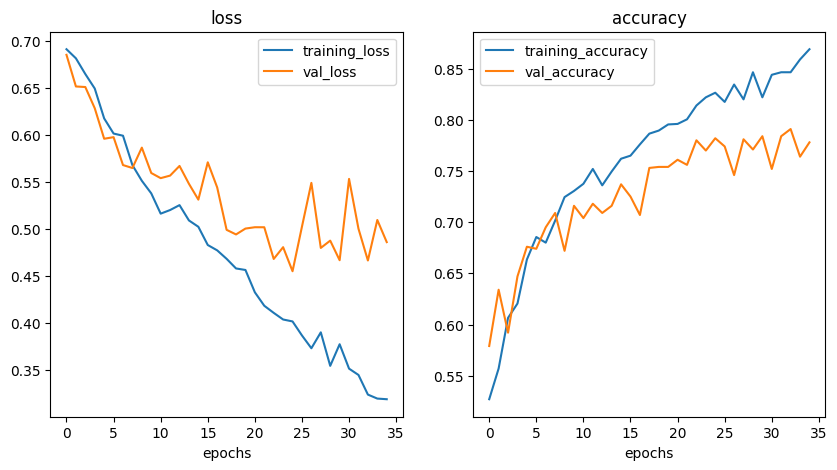

In [21]:
plot_loss_curves(history_9)

## Model 7 - New approach

Trying the model from this post: https://stackoverflow.com/questions/47701544/does-dropout-layer-go-before-or-after-dense-layer-in-tensorflow/47702111#47702111

In [38]:
model_6 = Sequential()
model_6.add(Conv2D(32, 3, activation='relu', input_shape=(150,150,3)))
model_6.add(MaxPool2D(2))
model_6.add(Conv2D(64, 3, activation='relu'))
model_6.add(MaxPool2D(2))
model_6.add(Flatten())
model_6.add(Dense(128, activation='relu'))
model_6.add(Dense(1, activation='sigmoid'))

In [39]:
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 82944)             0         
                                                                 
 dense_11 (Dense)            (None, 128)              

In [40]:
model_6.compile(loss='binary_crossentropy',
               optimizer=Adam(),
               metrics=['accuracy'])

In [41]:
history_6 = model_6.fit(train_data_aug,
                       epochs=10,
                       steps_per_epoch=len(train_data_aug),
                       validation_data=val_data,
                       validation_steps=len(val_data))

Epoch 1/10
63/63 [==============================] - 12s 179ms/step - loss: 1.0581 - accuracy: 0.4980 - val_loss: 0.6837 - val_accuracy: 0.5910
Epoch 2/10
63/63 [==============================] - 16s 252ms/step - loss: 0.6600 - accuracy: 0.6125 - val_loss: 0.6542 - val_accuracy: 0.6270
Epoch 3/10
63/63 [==============================] - 16s 255ms/step - loss: 0.6295 - accuracy: 0.6640 - val_loss: 0.6247 - val_accuracy: 0.6430
Epoch 4/10
63/63 [==============================] - 17s 268ms/step - loss: 0.6087 - accuracy: 0.6820 - val_loss: 0.6132 - val_accuracy: 0.6780
Epoch 5/10
63/63 [==============================] - 17s 268ms/step - loss: 0.5945 - accuracy: 0.6885 - val_loss: 0.6040 - val_accuracy: 0.7000
Epoch 6/10
63/63 [==============================] - 17s 266ms/step - loss: 0.5794 - accuracy: 0.7030 - val_loss: 0.5841 - val_accuracy: 0.6760
Epoch 7/10
63/63 [==============================] - 16s 251ms/step - loss: 0.5589 - accuracy: 0.7170 - val_loss: 0.5745 - val_accuracy: 0.7050

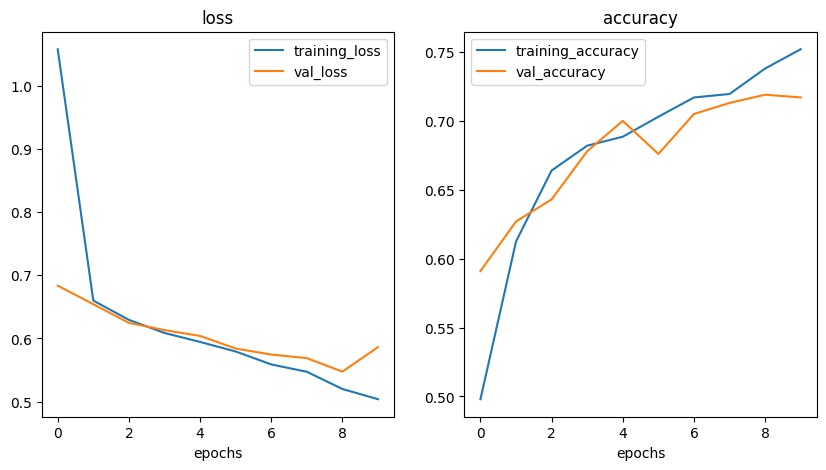

In [96]:
plot_loss_curves(history_6)

## Some things to try

- [x] more filters (i.e. 64)
- [x] add another Conv2D/MaxPool layer
- [x] add another Dense layer
- [x] more epochs
- [ ] Early stopping
- [ ] different augmentations
- [ ] Dropout layer (see [this example](https://stackoverflow.com/a/47702111/12101063))
- [ ] Use `flow` or `flow_from_dataframe` to combine train and val directories for more training images
- [ ] Use test images for validation?
- [ ] try [this example](https://stackoverflow.com/a/47702111/12101063)

## Use the model to make predictions

In [105]:
test_probs = model_4.predict(test_data)

1/1 [==============================] - 0s 312ms/step


In [106]:
test_probs.shape

(50, 1)

In [94]:
test_images = test_data.next()

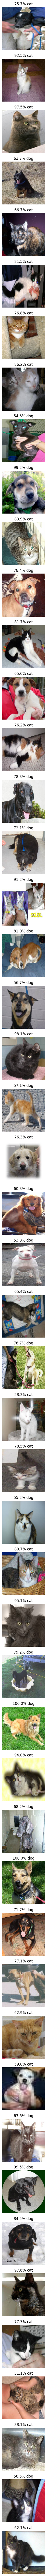

In [96]:
plot_images(test_images, p)

In [98]:
custom_dir = 'cats_and_dogs/custom'
custom_data_gen = ImageDataGenerator(rescale=1/255.)

In [99]:
custom_data = custom_data_gen.flow_from_directory(directory='cats_and_dogs',
                                                 target_size=(150,150),
                                                 batch_size=50,
                                                 classes=['custom'],
                                                 class_mode=None,
                                                 shuffle=False)

Found 15 images belonging to 1 classes.


In [100]:
custom_images = custom_data.next()

In [102]:
custom_probs = model_4.predict(custom_data)

1/1 [==============================] - 0s 330ms/step


In [103]:
custom_probs

array([[0.98731095],
       [0.56884456],
       [0.933377  ],
       [0.47017798],
       [0.32053643],
       [0.47213516],
       [0.2610447 ],
       [0.05497579],
       [0.19542876],
       [0.73692095],
       [0.31179386],
       [0.854176  ],
       [0.5316262 ],
       [0.92696035],
       [0.8075305 ]], dtype=float32)

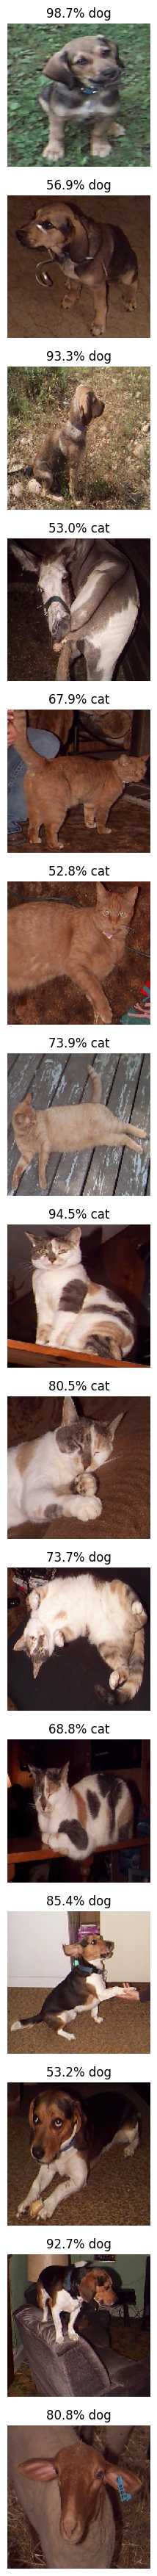

In [104]:
plot_images(custom_images, custom_probs)